# Simulación de Monte Carlo

La simulación de Montecarlo, o método de Montecarlo, le debe el nombre al famoso casino del principado de Mónaco. La ruleta es el juego de casino más famoso y también el ejemplo más sencillo de mecanismo que permite generar números aleatorios.

La clave de este método está en entender el término ‘simulación’. Realizar una simulación consiste en repetir, o duplicar, las características y comportamientos de un sistema real. Así pues, el objetivo principal de la simulación de Montecarlo es intentar imitar el comportamiento de variables reales para, en la medida de lo posible, analizar o predecir cómo van a evolucionar.

La Simulación de Monte Carlo existe para poder crear diferentes escenarios que pudiesen suceder mediante numeros aleatorios.

En esta sesión tenemos los datos del valor de las acciones de Wall Mart (Data Wallmart.xlsx) y queremos invertir en ellas, pero queremos saber los diferentes escenarios que puedan suceder. 

## Importar librerías
¡Vamos a importar algunas librerías para empezar!

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import random

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Carguemos los datos a una variable llamada df como dataframe mediante pandas

In [3]:
df = pd.read_excel('Data Wallmart.xlsx')

# Exploración inicial

In [4]:
df.head()

,Date,Adj Close
0,2018-12-31,90.130081
1,2019-01-02,90.313919
2,2019-01-03,89.849495
3,2019-01-04,90.410690
4,2019-01-07,91.475037


In [5]:
df.tail()

,Date,Adj Close
247,2019-12-23,117.503563
248,2019-12-24,117.977409
249,2019-12-26,117.987274
250,2019-12-27,118.056381
251,2019-12-30,117.868820


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       252 non-null    datetime64[ns]
 1   Adj Close  252 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.1 KB


<AxesSubplot:xlabel='Date'>

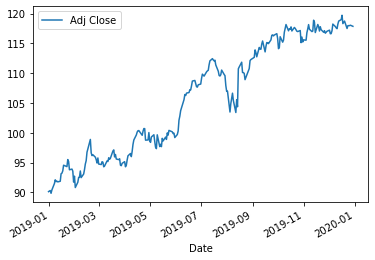

In [7]:
df.plot(x='Date')

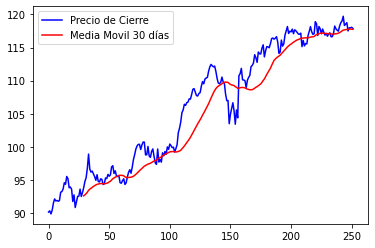

In [8]:
plt.plot(df['Adj Close'],color='blue', label='Precio de Cierre')
plt.plot(df.rolling(window=30).mean(), color='red', label='Media Movil 30 días')
plt.legend()
plt.show()

In [9]:
from sklearn.metrics import mean_absolute_error

#Funcion para automatizar la evaluacion de promedio moviles y valores atipicos
def GraficarPromedioMovil(df,ventana,intervalos=False,escala=1,
                          anomalias=False):
    
    promedio_movil = df.rolling(window=ventana).mean()
    
    plt.figure(figsize=(15,5))
    plt.title("Promedio movil\n ventana = {}".format(ventana))
    plt.plot(promedio_movil,"g",label="Tendencia de Promedio Movil")
    
    if intervalos:
        error_absoluto_medio = mean_absolute_error(df[ventana:],df.rolling(window=ventana).mean()[ventana:])
        desviacion_error = np.std(df[ventana:] - df.rolling(window=ventana).mean()[ventana:])
        banda_inferior = df.rolling(window=ventana).mean()[ventana:] - (error_absoluto_medio + escala*desviacion_error)
        banda_superior = df.rolling(window=ventana).mean()[ventana:] + (error_absoluto_medio + escala*desviacion_error)
        plt.plot(banda_superior,"r--", label="Banda Superior /Banda Inferior")
        plt.plot(banda_inferior,"r--")
        
    if anomalias:
        anomalias = pd.DataFrame(index=df.index, columns=df.columns)
        anomalias[df[ventana:]<banda_inferior] = df[ventana:][df[ventana:]<banda_inferior]
        anomalias[df[ventana:]>banda_superior] = df[ventana:][df[ventana:]>banda_superior]
        plt.plot(anomalias,"ro",markersize=10)
        
    plt.plot(df[ventana:], label="Valores reales")
    plt.legend(loc="upper left")
    plt.grid(True)

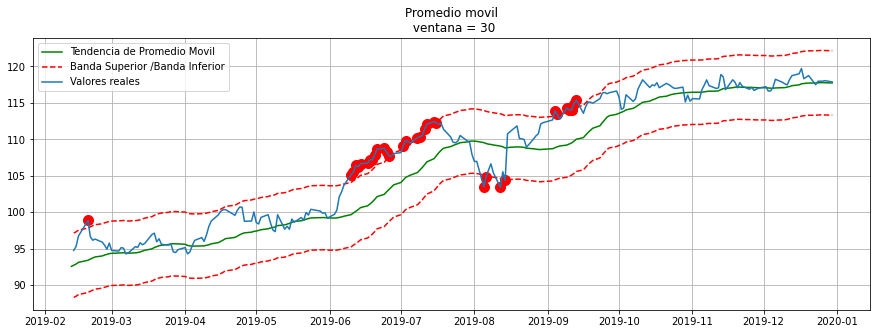

In [10]:
GraficarPromedioMovil(df.set_index('Date'),30,intervalos=True,anomalias=True)

# Descomposición de una Serie de Tiempo

**- Tendencia:** calcula usando un promedio móvil centrado de la serie de tiempo. La media móvil se calcula utilizando una longitud de ventana correspondiente a la frecuencia de la serie temporal. Por ejemplo, usaríamos una ventana de longitud 12 para datos mensuales, en el caso de nosotros los datos son diarios y utilizaremos una ventana de 1 año por lo cual, sería 365.

**- Estacionalidad:** Para calcular el componente estacional, primero debemos eliminar la tendencia de la serie temporal. Lo hacemos restando el componente de tendencia de la serie de tiempo original.

Una vez hecho esto, calculamos los valores promedio de la serie sin tendencia para cada período estacional. En el caso de los meses, calcularíamos el valor sin tendencia promedio para cada mes.

El componente estacional simplemente se construye a partir de los promedios estacionales repetidos a lo largo de toda la serie Nuevamente, este es uno de los argumentos en contra del uso de la descomposición estacional simple: no se permite que el componente estacional cambie con el tiempo, lo que puede ser una medida muy estricta, ademas de una suposición poco realista para series de tiempo largas.

**- Residuos:** El último componente es simplemente lo que queda después de eliminar (restando o dividiendo) los componentes de tendencia y estacionales de la serie de tiempo original.


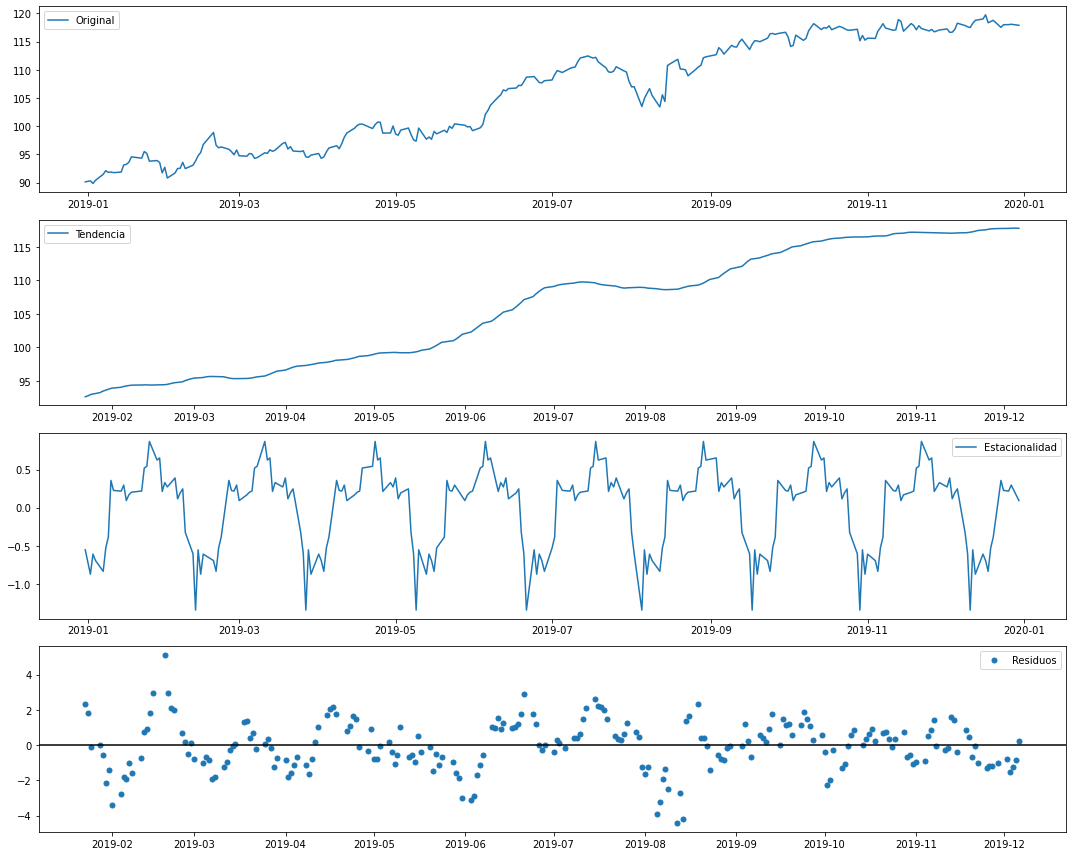

In [11]:
descomposicion = seasonal_decompose(df.set_index('Date'),period = 30)

tendencia = descomposicion.trend
estacionalidad = descomposicion.seasonal
residuos = descomposicion.resid
plt.figure(figsize=(15,12))
plt.subplot(411)
plt.plot(df.set_index('Date'), label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(tendencia, label='Tendencia')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(estacionalidad,label='Estacionalidad')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residuos, label='Residuos',marker='o', linestyle = 'None', markersize = 5)
plt.axhline(color='black')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# Evaluación de ganancias

Como pudimos ver es un dataframe con 2 columnas, fecha (el año 2019 completo) y Adj Close, que es el valor de las acciones de WallMart al terminar el día, la ganancia porcentual para cada día sería el valor de cierre del día actual menos el valor de cierre del día anterior dividido entre el valor de cierre del día anterior. Utilicemos el metodo pct_change() de pandas que nos permite realizar este cálculo fácil, para crear una variable en el dataframe llamada Ganancia.

In [12]:
df['Ganancias'] = df['Adj Close'].pct_change().dropna()

Analicemos la distribución de las ganancias, crea un histograma.

<AxesSubplot:>

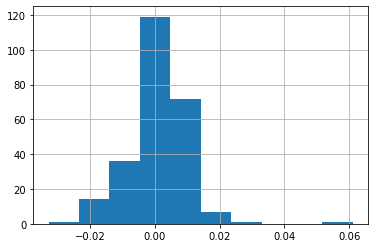

In [13]:
df['Ganancias'].hist()

## Planteamiento de la simulación

Partiendo del principo de una distribución de datos normal, que dice que con al promedio y la desviación estándar podemos predecir cualquier valor de esta distribución con un alto nivel de confianza, en este ejercicio vamos a crear diferentes escenarios posibles de ganancias, para esto haremos 20 escenarios proyectando los próximos 50 días a partir del último día disponible en la data, para cada día plantearemos 1000 simulaciones, es decir para cada día vamos a generar 1000 posibles ganancias  que compuestas generen el mismo promedio y la misma desviación estándar que las ganancias reales del 2019.

Iniciemos definiendo las variables que ya conocemos: dias, simulaciones, promedio y desviación estándar.

In [14]:
dias = 90
simulaciones = 1000
media = df['Ganancias'].mean()
desviacion = df['Ganancias'].std()

Creemos un dataframe que tenga las fechas de los proximos 50 días, partiendo del último día del dataframe df

In [15]:
fechas = []
for i in range(1,dias):
    dia = df['Date'].max()+pd.DateOffset(i)
    fechas.append([dia])
    
df_cambios = pd.DataFrame(fechas, columns=['fecha'])

Creemos un dataframe que tenga las fechas de los proximos 90 días, partiendo del último día del dataframe df

In [16]:
#lista vacia para agregar los precios aleatorios
precio_lista = [] 

#cantidad de escenarios
escenarios = 100 

#dataframe solo con las fechas a proyectar
escenarios_df = df_cambios[['fecha']] 

#para cada escenario
for escenario in list(range(escenarios)): 
    
    #asigna nombre de columna basado en el escenario con los valores de los precios
    escenarios_df['escenario_{}'.format(escenario)] = pd.Series(precio_lista)
    
    #vaciamos los precios de lista para poner el nuevo dia con los precios aleatorios
    precio_lista.clear() 
    
    #agrega el precio inicial a lista de precios para asignarle las ganancias aleatorias
    precio_lista.append(float(df[df['Date'] == df['Date'].max()]['Adj Close']))        
    
    #para cada dia de cada escenario
    for dia in range(1,dias):
        
        #creamos las simulaciones con la misma media y desviación estándar
        cambios = np.random.normal(media, desviacion, simulaciones)
        
        #el precio es el ultimo precio de la lista de precios multiplicado por un porcentaje de ganancia aleatorio de la lista de ganancias aletorias generadas
        precio =  precio_lista[-1] * (1+random.choice(cambios))
        
        #agregamos el precio a la lista de precios
        precio_lista.append(precio) 

In [17]:
# escenario 0 siempre queda en blanco
escenarios_df.head()

,fecha,escenario_0,escenario_1,escenario_2,escenario_3,escenario_4,escenario_5,escenario_6,escenario_7,escenario_8,...,escenario_90,escenario_91,escenario_92,escenario_93,escenario_94,escenario_95,escenario_96,escenario_97,escenario_98,escenario_99
0,2019-12-31,NaN,117.868820,117.868820,117.868820,117.868820,117.868820,117.868820,117.868820,117.868820,...,117.868820,117.868820,117.868820,117.868820,117.868820,117.868820,117.868820,117.868820,117.868820,117.868820
1,2020-01-01,NaN,117.909331,117.775695,117.641941,118.537086,118.005648,121.138512,117.251180,118.441996,...,118.896168,118.095055,115.871651,118.312053,118.190522,117.043878,117.048013,118.920821,120.688453,116.798219
2,2020-01-02,NaN,119.689367,117.511995,118.665730,118.719593,119.025252,120.078524,118.210528,121.457795,...,119.915829,118.274136,116.111365,119.251522,118.155983,118.550586,118.017671,120.759030,120.339255,118.018519
3,2020-01-03,NaN,119.098789,117.041689,118.490537,119.042371,118.658652,117.576851,118.612725,122.658946,...,120.009529,119.898209,117.996358,118.660050,118.557308,119.641192,116.991333,121.645526,118.490801,118.808662
4,2020-01-04,NaN,118.453889,116.028120,119.819571,120.160135,118.129098,118.749079,117.806310,122.853874,...,119.885509,121.084820,120.073696,118.277232,118.848016,119.305320,118.001357,122.186545,119.317556,119.078976


In [18]:
#eliminar el escenario 0
escenarios_df.drop('escenario_0', axis=1,inplace=True)

<AxesSubplot:xlabel='fecha'>

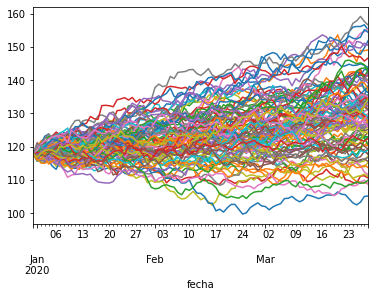

In [19]:
#graficamos los escenarios.
escenarios_df.plot(x='fecha',legend=False)
#plt.legend(bbox_to_anchor=(1.05,1))

In [20]:
#creando bandas de confianza basado en percentiles
escenarios_df['perc_05'] = escenarios_df.quantile(0.05,axis=1)
escenarios_df['perc_15'] = escenarios_df.quantile(0.15,axis=1)
escenarios_df['perc_25'] = escenarios_df.quantile(0.25,axis=1)
escenarios_df['perc_50'] = escenarios_df.quantile(0.50,axis=1)
escenarios_df['perc_75'] = escenarios_df.quantile(0.75,axis=1)
escenarios_df['perc_95'] = escenarios_df.quantile(0.95,axis=1)
escenarios_df['avg'] = escenarios_df.mean(axis=1)

No handles with labels found to put in legend.


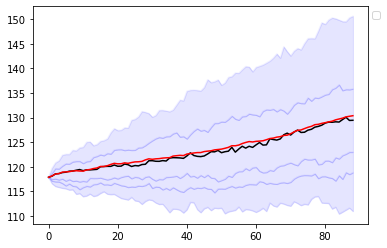

In [21]:
#graficamos los escenarios.
plt.plot(escenarios_df[['perc_05','perc_15','perc_25','perc_75','perc_95']],color='blue',alpha=0.05)
plt.plot(escenarios_df[['perc_50']],color='black')
plt.plot(escenarios_df[['avg']],color='red')
plt.fill_between(escenarios_df.index,escenarios_df['perc_05'],escenarios_df['perc_15'],color='blue',alpha=0.1)
plt.fill_between(escenarios_df.index,escenarios_df['perc_15'],escenarios_df['perc_25'],color='blue',alpha=0.1)
plt.fill_between(escenarios_df.index,escenarios_df['perc_25'],escenarios_df['perc_75'],color='blue',alpha=0.1)
plt.fill_between(escenarios_df.index,escenarios_df['perc_75'],escenarios_df['perc_95'],color='blue',alpha=0.1)
plt.legend(bbox_to_anchor=(1.05,1))

In [22]:
#un poquito de ingeniería de variables para juntar las simulaciones con los resultados reales
escenarios_df.rename(columns={'fecha':'Date'},inplace=True)

In [23]:
#unificando dataframes de simulaciones con datos reales
df_concat = pd.concat([df,escenarios_df], axis=0) 
df_concat.reset_index(drop=True, inplace=True)
#eliminando columna innecesaria
df_concat.drop('Ganancias', axis='columns', inplace=True)
df_concat.head()

,Date,Adj Close,escenario_1,escenario_2,escenario_3,escenario_4,escenario_5,escenario_6,escenario_7,escenario_8,...,escenario_97,escenario_98,escenario_99,perc_05,perc_15,perc_25,perc_50,perc_75,perc_95,avg
0,2018-12-31,90.130081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-02,90.313919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-03,89.849495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-04,90.410690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-07,91.475037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='Date'>

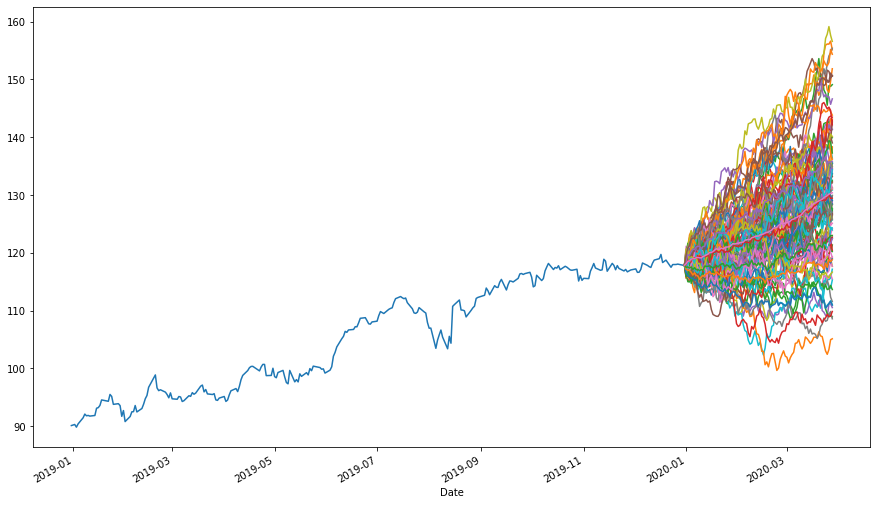

In [24]:
#graficando la tendencia real con la tendencia simulada
df_concat.plot(x='Date',figsize=(15,9),legend=False)
#plt.legend(bbox_to_anchor=(1.05,1))

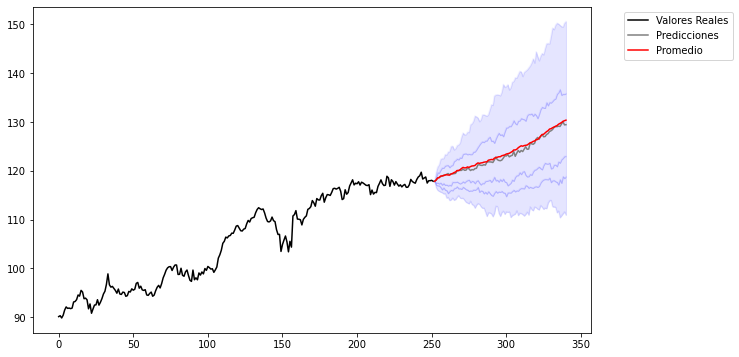

In [25]:
#Grafico con bandas de confianza
plt.figure(figsize=(10,6))
plt.plot(df_concat[['Adj Close']],color='black', label='Valores Reales')
plt.plot(df_concat[['perc_05','perc_15','perc_25','perc_75','perc_95']],color='blue',alpha=0.05)
plt.plot(df_concat[['perc_50']],color='gray',label='Predicciones')
plt.plot(df_concat[['avg']],color='red',label='Promedio')
plt.fill_between(df_concat.index,df_concat['perc_05'],df_concat['perc_15'],color='blue',alpha=0.1)
plt.fill_between(df_concat.index,df_concat['perc_15'],df_concat['perc_25'],color='blue',alpha=0.1)
plt.fill_between(df_concat.index,df_concat['perc_25'],df_concat['perc_75'],color='blue',alpha=0.1)
plt.fill_between(df_concat.index,df_concat['perc_75'],df_concat['perc_95'],color='blue',alpha=0.1)
plt.legend(bbox_to_anchor=(1.05,1))
plt.show()

## Analizando los resultados

In [26]:
df_descripciones_escenarios = escenarios_df.drop(['perc_05',
                                  'perc_15',
                                  'perc_25',
                                  'perc_50',
                                  'perc_75',
                                  'perc_95'],axis=1).describe()[1:].transpose()

In [27]:
print("Resultados del escenario simulado con tendencia más alcista:")
print('Último precio registrado: {}'.format(float(df[df['Date'] == df['Date'].max()]['Adj Close'])))

for column in df_descripciones_escenarios.columns:
    
    print(column + ': ' + str(round(df_descripciones_escenarios[column].max(),2)))

Resultados del escenario simulado con tendencia más alcista:
Último precio registrado: 117.86882
mean: 138.55
std: 11.57
min: 117.87
25%: 132.71
50%: 142.24
75%: 146.55
max: 159.13


In [28]:
print("Resultados del escenario simulado con tendencia más bajista:")
print('Último precio registrado: {}'.format(float(df[df['Date'] == df['Date'].max()]['Adj Close'])))

for column in df_descripciones_escenarios.columns:
    
    print(column + ': ' + str(round(df_descripciones_escenarios[column].min(),2)))

Resultados del escenario simulado con tendencia más bajista:
Último precio registrado: 117.86882
mean: 108.8
std: 1.09
min: 99.67
25%: 103.28
50%: 105.99
75%: 112.22
max: 117.87


In [29]:
print("Resultados del escenario más probable todos los escenarios simulados:")
print('Último precio registrado: {}'.format(float(df[df['Date'] == df['Date'].max()]['Adj Close'])))

for column in df_descripciones_escenarios.columns:
    
    print(column + ': ' + str(round(df_descripciones_escenarios[column].mean(),2)))

Resultados del escenario más probable todos los escenarios simulados:
Último precio registrado: 117.86882
mean: 123.6
std: 4.99
min: 114.93
25%: 119.61
50%: 123.33
75%: 127.35
max: 133.52
